https://www.tensorflow.org/guide/core/logistic_regression_core

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn import preprocessing

import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.18.0


In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']

for attr in ['mean', 'ste', 'largest']:
    for feature in features:
        column_names.append(feature + "_" + attr)

In [4]:
dataset = pd.read_csv(url, names=column_names)

In [5]:
dataset.shape

(569, 32)

In [6]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave_poinits_mean       569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_ste                 569 non-null    float64
 13  texture_ste                569 non-null    float64

In [7]:
train_dataset = dataset.sample(frac=0.75, random_state=1)

In [8]:
len(train_dataset)

427

In [9]:
test_dataset = dataset.drop(labels=train_dataset.index)

In [10]:
len(test_dataset)

142

In [11]:
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

In [27]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

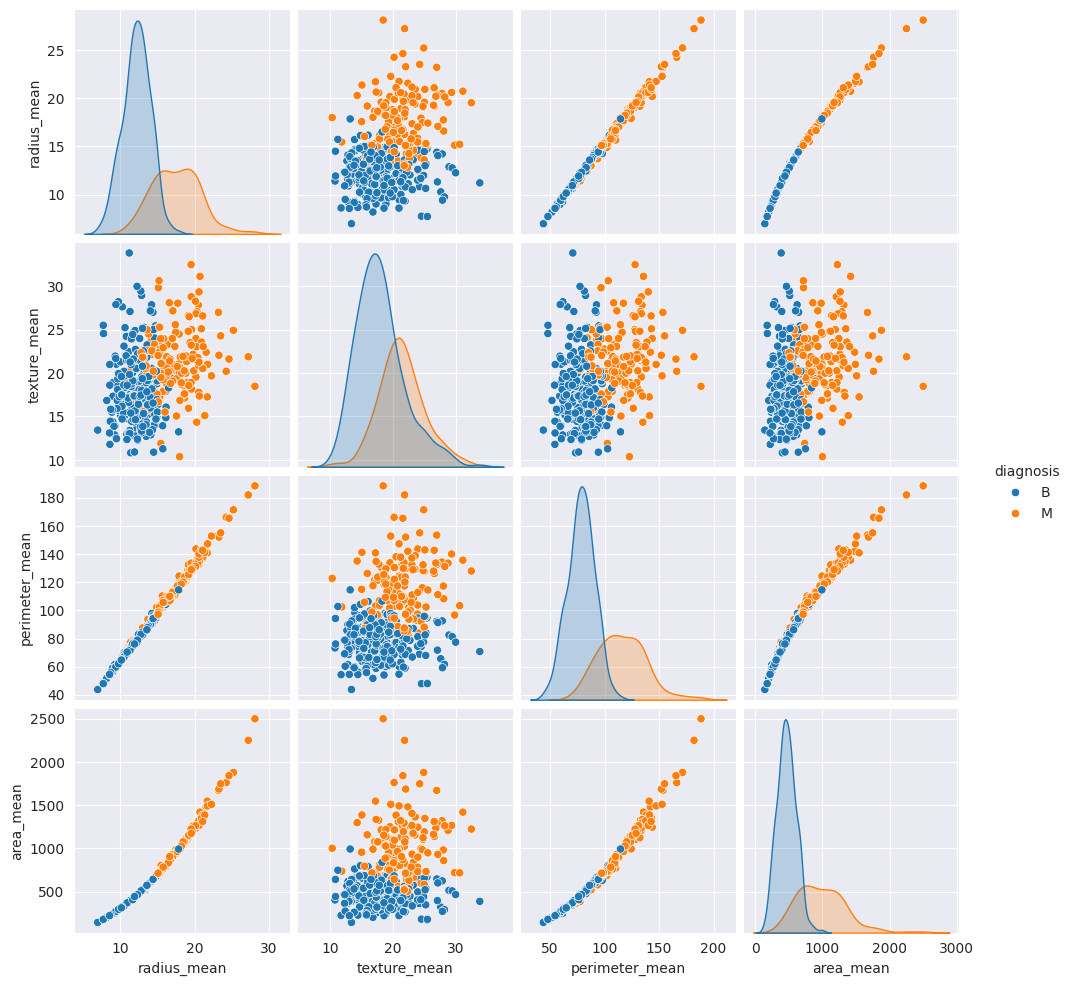

In [28]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');


In [29]:
train_dataset.describe().transpose()[:10]


,count,mean,std,min,25%,50%,75%,max
id,427.0,2.756014e+07,1.162735e+08,8670.00000,865427.500000,905539.00000,8.810829e+06,9.113205e+08
radius_mean,427.0,1.414331e+01,3.528717e+00,6.98100,11.695000,13.43000,1.594000e+01,2.811000e+01
texture_mean,427.0,1.924468e+01,4.113131e+00,10.38000,16.330000,18.84000,2.168000e+01,3.381000e+01
perimeter_mean,427.0,9.206759e+01,2.431431e+01,43.79000,75.235000,86.87000,1.060000e+02,1.885000e+02
area_mean,427.0,6.563190e+02,3.489106e+02,143.50000,420.050000,553.50000,7.908500e+02,2.499000e+03
smoothness_mean,427.0,9.633618e-02,1.436820e-02,0.05263,0.085850,0.09566,1.050000e-01,1.634000e-01
compactness_mean,427.0,1.036597e-01,5.351893e-02,0.02344,0.063515,0.09182,1.296500e-01,3.454000e-01
concavity_mean,427.0,8.833008e-02,7.965884e-02,0.00000,0.029570,0.05999,1.297500e-01,4.268000e-01
concave_poinits_mean,427.0,4.872688e-02,3.853594e-02,0.00000,0.019650,0.03390,7.409500e-02,2.012000e-01
symmetry_mean,427.0,1.804597e-01,2.637837e-02,0.12030,0.161700,0.17840,1.947000e-01,2.906000e-01


In [30]:
class Normalize(tf.Module):
    def __init__(self, x):
        self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
        self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

    def norm(self, x):
        return (x - self.mean) / self.std

    def unnorm(self, x):
        return x * self.std + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

In [31]:
def log_loss(y_pred, y):
    # Compute the log loss function
    ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(ce)

In [60]:
class LogisticRegression(tf.Module):

    def __init__(self):
        self.built = False

    def __call__(self, x, train=True):
        # Initialize the model parameters on the first call
        if not self.built:
            # Randomly generate the weights and the bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
        # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
            return z
        return tf.sigmoid(z)

In [94]:
log_reg = LogisticRegression()
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.99821407, 0.9986206 , 0.11537718, 0.15908867, 0.45434985],
      dtype=float32)

In [95]:
def predict_class(y_pred, thresh=0.5):
    # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
    return tf.cast(y_pred > thresh, tf.float32)

In [96]:
def accuracy(y_pred, y):
    # Return the proportion of matches between `y_pred` and `y`
    y_pred = tf.math.sigmoid(y_pred)
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y,tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

In [97]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [98]:
epochs = 1000
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_test, batch_accs_test = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = log_reg(x_batch)
            batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Update the parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, log_reg.variables)
        for g,v in zip(grads, log_reg.variables):
            v.assign_sub(learning_rate * g)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_accs_train.append(batch_acc)

    # Iterate over the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = log_reg(x_batch)
        batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Keep track of batch-level testing performance
        batch_losses_test.append(batch_loss)
        batch_accs_test.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.392
Epoch: 20, Training log loss: 0.245
Epoch: 40, Training log loss: 0.169
Epoch: 60, Training log loss: 0.123
Epoch: 80, Training log loss: 0.103
Epoch: 100, Training log loss: 0.095
Epoch: 120, Training log loss: 0.089
Epoch: 140, Training log loss: 0.085
Epoch: 160, Training log loss: 0.080
Epoch: 180, Training log loss: 0.079
Epoch: 200, Training log loss: 0.075
Epoch: 220, Training log loss: 0.079
Epoch: 240, Training log loss: 0.076
Epoch: 260, Training log loss: 0.072
Epoch: 280, Training log loss: 0.070
Epoch: 300, Training log loss: 0.070
Epoch: 320, Training log loss: 0.067
Epoch: 340, Training log loss: 0.067
Epoch: 360, Training log loss: 0.066
Epoch: 380, Training log loss: 0.068
Epoch: 400, Training log loss: 0.065
Epoch: 420, Training log loss: 0.065
Epoch: 440, Training log loss: 0.064
Epoch: 460, Training log loss: 0.061
Epoch: 480, Training log loss: 0.063
Epoch: 500, Training log loss: 0.062
Epoch: 520, Training log loss: 0.061
Epoch: 

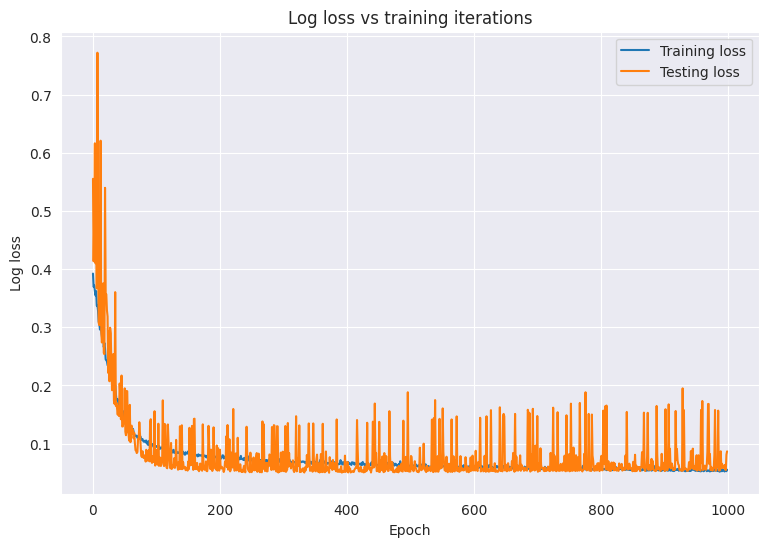

In [99]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

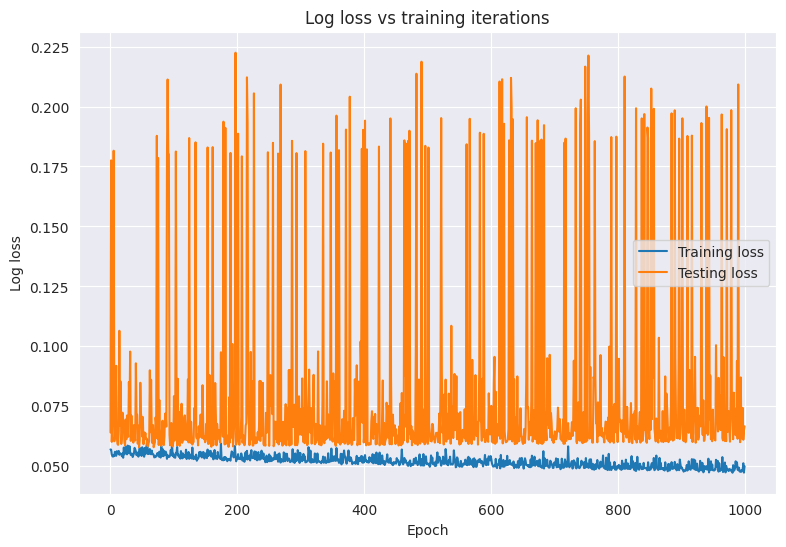

In [55]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

In [69]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")b
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");


SyntaxError: invalid syntax (1430998379.py, line 3)

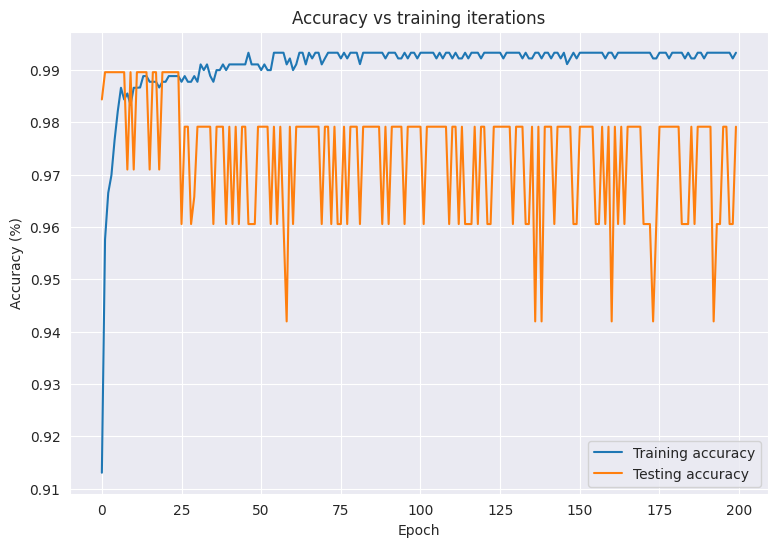

In [70]:

plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");


In [52]:
### 1000 epochs
epochs = 1000
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_test, batch_accs_test = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = log_reg(x_batch)
            batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Update the parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, log_reg.variables)
        for g,v in zip(grads, log_reg.variables):
            v.assign_sub(learning_rate * g)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_accs_train.append(batch_acc)

    # Iterate over the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = log_reg(x_batch)
        batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Keep track of batch-level testing performance
        batch_losses_test.append(batch_loss)
        batch_accs_test.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.057
Epoch: 20, Training log loss: 0.054
Epoch: 40, Training log loss: 0.056
Epoch: 60, Training log loss: 0.055
Epoch: 80, Training log loss: 0.058
Epoch: 100, Training log loss: 0.054
Epoch: 120, Training log loss: 0.053
Epoch: 140, Training log loss: 0.056
Epoch: 160, Training log loss: 0.055
Epoch: 180, Training log loss: 0.053
Epoch: 200, Training log loss: 0.053
Epoch: 220, Training log loss: 0.052
Epoch: 240, Training log loss: 0.054
Epoch: 260, Training log loss: 0.053
Epoch: 280, Training log loss: 0.053
Epoch: 300, Training log loss: 0.052
Epoch: 320, Training log loss: 0.052
Epoch: 340, Training log loss: 0.051
Epoch: 360, Training log loss: 0.051
Epoch: 380, Training log loss: 0.052
Epoch: 400, Training log loss: 0.053
Epoch: 420, Training log loss: 0.051
Epoch: 440, Training log loss: 0.052
Epoch: 460, Training log loss: 0.052
Epoch: 480, Training log loss: 0.051
Epoch: 500, Training log loss: 0.051
Epoch: 520, Training log loss: 0.052
Epoch: 

2025-01-17 17:19:29.224271: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 860, Training log loss: 0.054
Epoch: 880, Training log loss: 0.049
Epoch: 900, Training log loss: 0.050
Epoch: 920, Training log loss: 0.049
Epoch: 940, Training log loss: 0.049
Epoch: 960, Training log loss: 0.048
Epoch: 980, Training log loss: 0.047


In [49]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {tbest_losses[-1]:.3f}")

Final training log loss: 0.055
Final testing log Loss: 0.070


In [113]:
y_train

421    B
47     M
292    B
186    M
414    M
      ..
170    B
401    B
389    M
525    B
54     M
Name: diagnosis, Length: 427, dtype: object

In [20]:
from sklearn.linear_model import LogisticRegression
y_train_prep = [1 if x == 'M' else 0 for x in y_train]
x_train_prep = preprocessing.normalize(x_train)
clf = LogisticRegression(max_iter=100000, class_weight='balanced')
clf.fit(x_train_prep, y_train_prep)

LogisticRegression(class_weight='balanced', max_iter=100000)

In [23]:
x_test_prep = preprocessing.normalize(x_test)
y_test_prep = [1 if x == 'M' else 0 for x in y_test]

clf.score(x_test_prep, y_test_prep)
# pred = clf.predict(x_test_prep)
# sk_metrics.accuracy_score(y_test_prep, pred)

0.9084507042253521

In [53]:

print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.050
Final testing log Loss: 0.067


In [44]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.965
Final testing accuracy: 0.979


In [54]:

print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.988
Final testing accuracy: 0.984


In [45]:
def show_confusion_matrix(y, y_classes, typ):
    # Compute the confusion matrix and normalize it
    plt.figure(figsize=(10,10))
    confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
    axis_labels = range(2)
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title(f"Confusion matrix: {typ}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

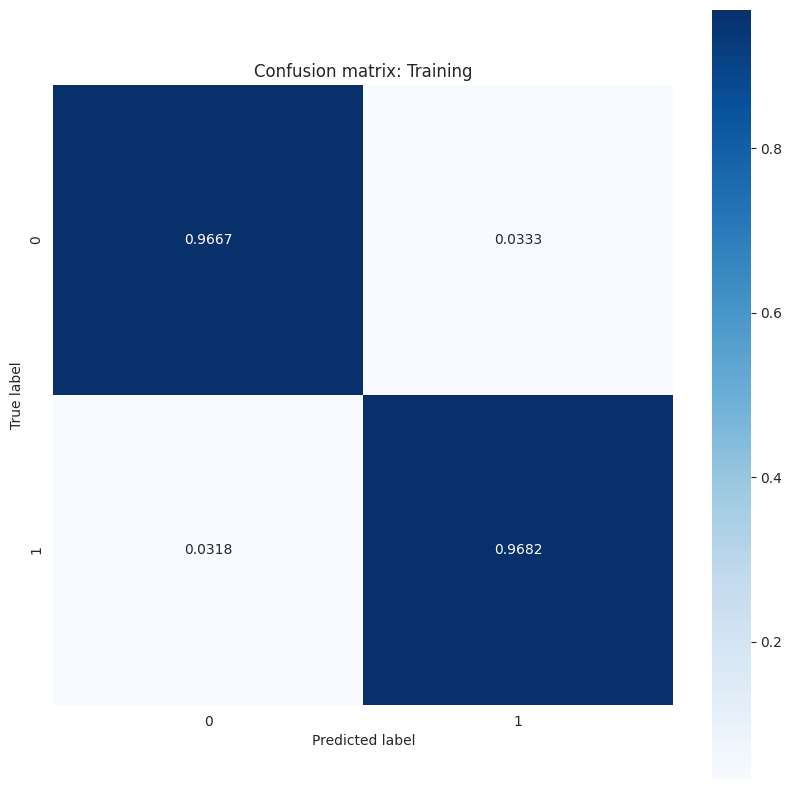

In [46]:
show_confusion_matrix(y_train, train_classes, 'Training')


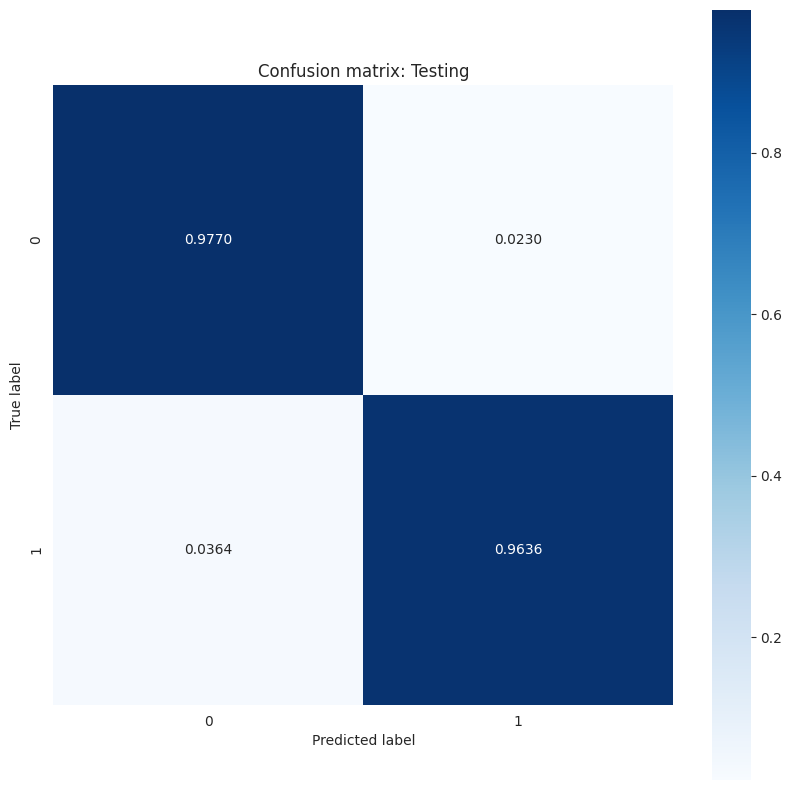

In [47]:
show_confusion_matrix(y_test, test_classes, 'Testing')


In [ ]:
class ExportModule(tf.Module):
    def __init__(self, model, norm_x, class_pred):
        # Initialize pre- and post-processing functions
        self.model = model
        self.norm_x = norm_x
        self.class_pred = class_pred

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def __call__(self, x):
        # Run the `ExportModule` for new data points
        x = self.norm_x.norm(x)
        y = self.model(x, train=False)
        y = self.class_pred(y)
        return y